In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pystan
import seaborn as sns
sns.set(color_codes=True)
import scipy as sp
import pickle

# Load Data

In [2]:
teams = pd.read_csv("./data/soccerpowerindex.txt", sep=" ", header = None)
teams.columns = ['teams']
nteams = len(teams)
prior_score = np.arange(1,nteams+1)
prior_score = prior_score[::-1]
prior_score = (prior_score - np.mean(prior_score))/(2*np.std(prior_score))

data2012 = pd.read_csv("./data/worldcup2012.txt", sep=" ", header = None)
ngames = data2012.shape[0]

team1 = [teams[teams['teams']==x].index.values[0] for x in data2012[0]]
score1 = data2012[data2012.columns[1]]
team2 = [teams[teams['teams']==x].index.values[0] for x in data2012[2]]
score2 = data2012[data2012.columns[3]]

df = 7

# Define Model

In [3]:
model_code = """
data {
  int<lower=0> nteams;
  int<lower=0> ngames;
  vector[nteams] prior_score;
  int<lower=0> team1[ngames];
  int<lower=0> team2[ngames];
  vector[ngames] score1;
  vector[ngames] score2;
  real<lower=0> df;
}
transformed data {
  vector[ngames] dif;
  dif = score1 - score2;
}
parameters {
  real b;
  real<lower=0> sigma_a;
  real<lower=0> sigma_y;
  vector[nteams] eta_a;
}
transformed parameters {
  vector[nteams] a;
  a = b*prior_score + sigma_a*eta_a;
}  
model {
  eta_a ~ normal(0,1);
  for (i in 1:ngames)
    dif[i] ~ student_t(df, a[team1[i]+1]-a[team2[i]+1], sigma_y);
}
"""

# The data dictionary:

In [4]:
data_dict = {'nteams': nteams, 'ngames': ngames, 'team1': team1,
  'score1': score1, 'team2': team2, 'score2': score2, 'prior_score': prior_score,
  'df': df}

# Compiling and fitting the model:

In [5]:
n_iter = 1000
n_chains = 4
model = pystan.StanModel(model_code=model_code)
fit = model.sampling(data=data_dict, iter=n_iter, chains=n_chains)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e316a23324acb5653bba5c87c13d3bdd NOW.


In [6]:
print(fit)

Inference for Stan model: anon_model_e316a23324acb5653bba5c87c13d3bdd.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
b           1.22  8.1e-3   0.28   0.66   1.04   1.22   1.41   1.78   1171    1.0
sigma_a     0.32  9.5e-3    0.2   0.01   0.16    0.3   0.44   0.79    450    1.0
sigma_y     1.29  4.1e-3   0.16   1.02   1.19   1.28   1.39   1.64   1535    1.0
eta_a[1]   -0.09    0.02    0.9  -1.76  -0.71  -0.09   0.54   1.73   2376    1.0
eta_a[2]   -0.12    0.02    0.9  -1.85  -0.71  -0.13   0.49   1.56   2570    1.0
eta_a[3]    0.39    0.02   0.97  -1.61  -0.21    0.4   1.03   2.19   2202    1.0
eta_a[4]   -0.43    0.02   1.02  -2.46  -1.12  -0.41   0.23   1.62   2000    1.0
eta_a[5]    0.02    0.02   0.89  -1.68  -0.57 2.3e-3   0.61    1.8   2322    1.0
eta_a[6]    0.35    0.02   0.92  -1.53  -0.25   0.37   0.98   2.13   2636    1.0
eta

In [7]:
# save it to the file 'worldcup.pkl' for later use:
with open('./model/worldcup.pkl', 'wb') as f:
    pickle.dump(model, f)
# load it again:
model = pickle.load(open('./model/worldcup.pkl', 'rb'))

# Plot results:

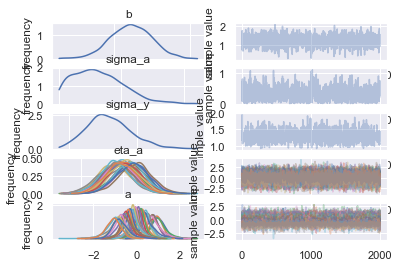

In [8]:
fit.plot()
# plt.savefig('SummaryPlot.png')
plt.show()

# Boxplot:

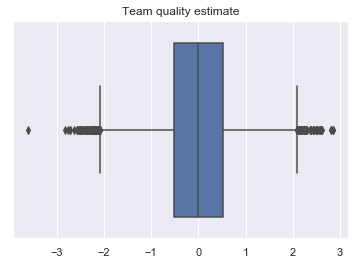

In [9]:
params_a = pd.DataFrame(fit.extract(['a'],permuted=True)['a'])
params_a.rename(columns=lambda x: 'a'+ str(x), inplace=True)
params_a_mean = params_a.mean(axis=0)
params_a_se = params_a.std(axis=0)

sns.boxplot(params_a, orient="h")
plt.title('Team quality estimate')
# plt.savefig('Boxplot.png')
plt.show()

# Plotting estimates and residuals:

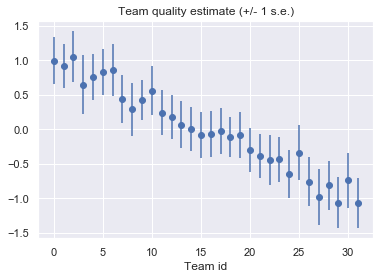

In [10]:
# sns.barplot(data=params_a, orient="h", ci=95)
# plt.show()
x = np.arange(0,nteams)
y = np.array(params_a_mean)
plt.scatter(x,y)
yerr = np.array(params_a_se)
plt.errorbar(x,y,yerr=yerr, linestyle="None")
plt.title('Team quality estimate (+/- 1 s.e.)')
plt.xlabel('Team id')
# plt.savefig('Errorbar.png')
plt.show()

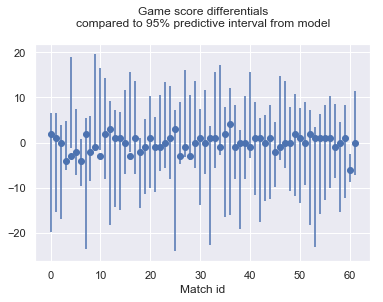

In [11]:
# below is wrong...
expected_diff = params_a_mean.iloc[team1].reset_index(drop=True) - params_a_mean.iloc[team2].reset_index(drop=True)
params_sigma_y = pd.DataFrame(fit.extract(['sigma_y'],permuted=True)['sigma_y'])
interval_975 = np.median(sp.stats.t.ppf(.975, df, loc=0, scale=1)*params_sigma_y)
def SignedSquare(a):
    return np.sign(a)*a**2
score_diff = score1 - score2
lower_error = score_diff - SignedSquare(expected_diff - interval_975)
upper_error = score_diff + SignedSquare(expected_diff + interval_975)

asymmetric_error = pd.concat([upper_error, lower_error], axis=1).values.T

x = np.arange(0,ngames)
y = score_diff
plt.scatter(x,y)
plt.errorbar(x,y,yerr=asymmetric_error, linestyle="None")
plt.title('Game score differentials\ncompared to 95% predictive interval from model\n')
plt.xlabel('Match id')
# plt.savefig('GameScore.png')
plt.show()